# Galactic dust realization

In this notebook we run PySM to generate a galactic dust map and analyze that map using the cl spectrum.

Then we check the impact of the following:
- From sky map to 2D cartesian.
- Cropped image.
- Lower resolution realization.
- Save and read image file.

In [1]:
# pip install numpy==1.26.4 scipy==1.13.1 pixell==0.26.0
#%pip install pysm3[test] healpy

In [2]:
import pysm3
from matplotlib import pyplot as plt
from matplotlib.image import imread
import numpy as np
import pixell
from pysm3 import units as u
import healpy as hp

## Define the resolution

In [3]:
nside = 256  # higher for high resolution
healpix_reso = hp.nside2resol(nside) * u.radian
healpix_reso.to(u.arcmin)

<Quantity 13.74194565 arcmin>

In [4]:
npix = hp.nside2npix(nside)
print(npix / 1e6, "Mpix")

0.786432 Mpix


## PySM simulation

In [5]:
seed = 101

In [6]:
dust = pysm3.ModifiedBlackBodyRealization(
    nside=nside,
    amplitude_modulation_temp_alm="dust_gnilc/raw/gnilc_dust_temperature_modulation_alms_lmax768.fits.gz",
    amplitude_modulation_pol_alm="dust_gnilc/raw/gnilc_dust_polarization_modulation_alms_lmax768.fits.gz",
    largescale_alm="dust_gnilc/raw/gnilc_dust_largescale_template_logpoltens_alm_nside2048_lmax1024_complex64.fits.gz",
    small_scale_cl="dust_gnilc/raw/gnilc_dust_small_scales_logpoltens_cl_lmax16384.fits.gz",
    largescale_alm_mbb_index="dust_gnilc/raw/gnilc_dust_largescale_template_beta_alm_nside2048_lmax1024.fits.gz",
    small_scale_cl_mbb_index="dust_gnilc/raw/gnilc_dust_small_scales_beta_cl_lmax16384_2023.06.06.fits.gz",
    largescale_alm_mbb_temperature="dust_gnilc/raw/gnilc_dust_largescale_template_Td_alm_nside2048_lmax1024.fits.gz",
    small_scale_cl_mbb_temperature="dust_gnilc/raw/gnilc_dust_small_scales_Td_cl_lmax16384_2023.06.06.fits.gz",
    freq_ref="353 GHz",
    seeds=[seed, seed + 1000, seed + 2000],
    max_nside=8192,
)

/home/javierhn/venv_SR_map_generation/lib/python3.12/site-packages/healpy/fitsfunc.py:648: ComplexWarning: Casting complex values to real discards the imaginary part
  alm.real[i] = almr
/home/javierhn/venv_SR_map_generation/lib/python3.12/site-packages/healpy/fitsfunc.py:649: ComplexWarning: Casting complex values to real discards the imaginary part
  alm.imag[i] = almi
/home/javierhn/venv_SR_map_generation/lib/python3.12/site-packages/healpy/fitsfunc.py:648: ComplexWarning: Casting complex values to real discards the imaginary part
  alm.real[i] = almr
/home/javierhn/venv_SR_map_generation/lib/python3.12/site-packages/healpy/fitsfunc.py:649: ComplexWarning: Casting complex values to real discards the imaginary part
  alm.imag[i] = almi
/home/javierhn/venv_SR_map_generation/lib/python3.12/site-packages/healpy/sphtfunc.py:610: ComplexWarning: Casting complex values to real discards the imaginary part
  (np.asarray(cl, dtype=np.float64) if cl is not None else None)
/home/javierhn/venv_S

In [7]:
sky = pysm3.Sky(nside=nside, component_objects=[dust])

In [8]:
freq = 353 * u.GHz

In [9]:
m = sky.get_emission(freq)

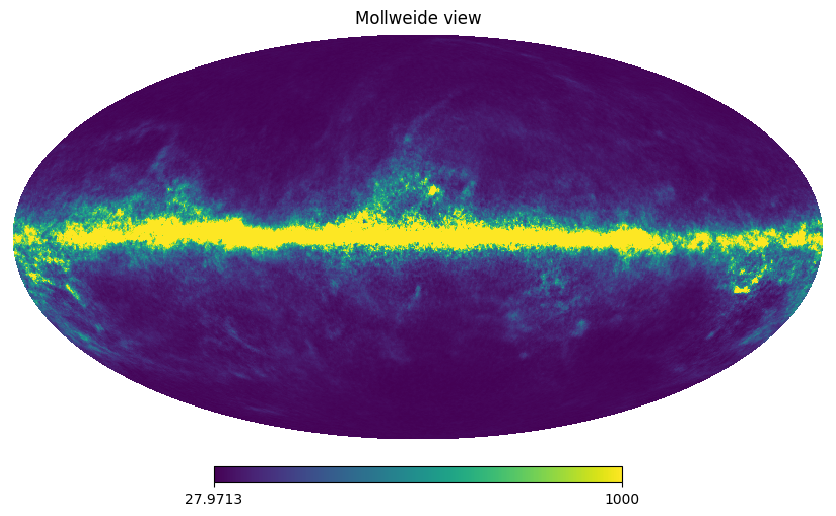

In [10]:
hp.mollview(m[0], max=1e3)

### alm and cl calculation

In [11]:
alm=hp.map2alm(m[0])
cl=pixell.curvedsky.alm2cl(alm)

Text(0.5, 1.0, '$c_l$ spectrum')

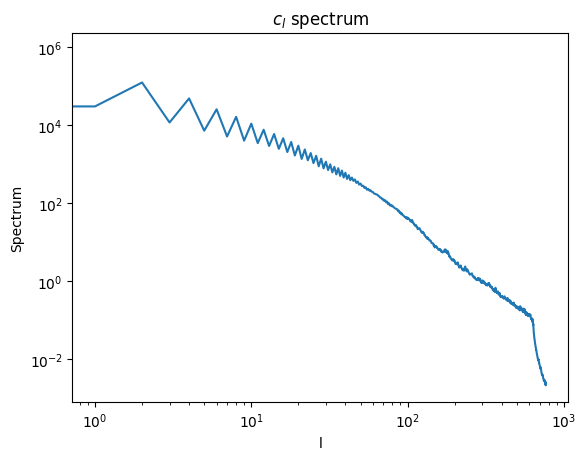

In [12]:
plt.plot(cl)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('l')
plt.ylabel('Spectrum')
plt.title(r'$c_l$ spectrum')

## Convert sky map to 2D

In [13]:
car_reso = (np.pi / np.round(np.pi / healpix_reso.value)) * u.radian
print(healpix_reso.to(u.arcmin), car_reso.to(u.arcmin))

13.741945647269624 arcmin 13.740458015267174 arcmin


In [14]:
pixell.__version__

'0.26.0'

In [15]:
m_car = pysm3.apply_smoothing_and_coord_transform(
    m, output_car_resol=car_reso, return_healpix=False, return_car=True
)

In [16]:
m_car.shape

(3, 786, 1572)

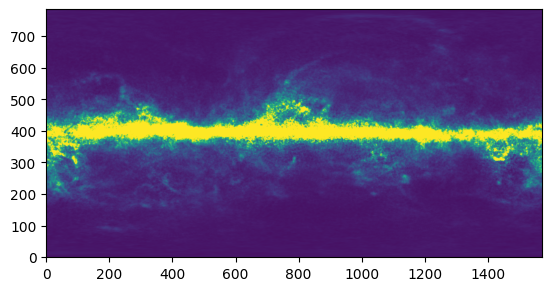

In [17]:
plt.imshow(m_car[0,:,:], vmin=0, vmax=700, origin="lower")

## Calculate the alm and cl from the 2D map

In [18]:
lmax=3*nside-1
print('lmax is:',lmax)
print('nside is:',nside)

lmax is: 767
nside is: 256


In [19]:
alm_car = pixell.curvedsky.map2alm(m_car,lmax=lmax)

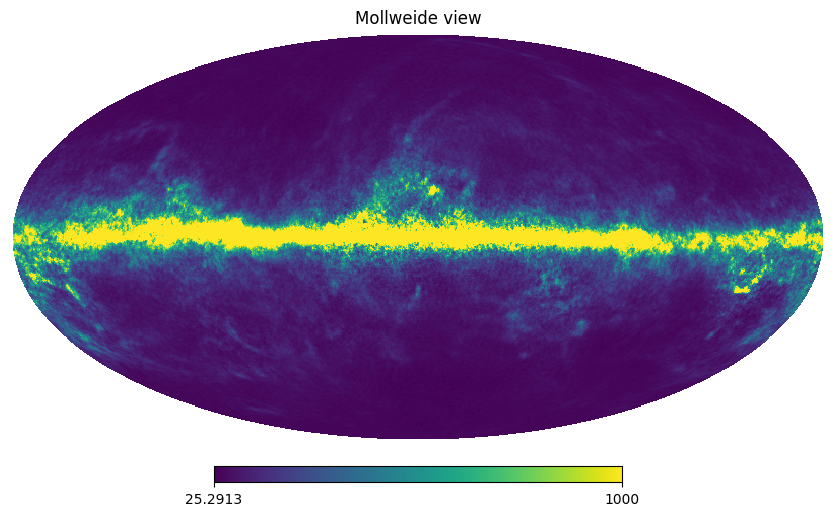

In [20]:
#reconstruct the sky image from the 2D alm
hp.mollview(hp.alm2map(alm_car, nside=nside)[0], max=1e3)

In [21]:
#calculate the cl from the 2D map
cl_car=pixell.curvedsky.alm2cl(alm_car[0])

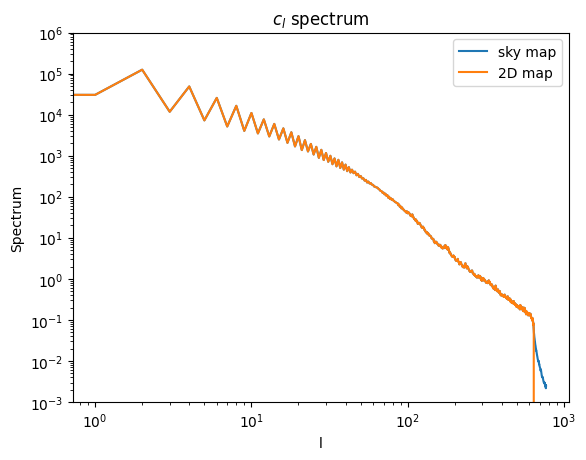

In [22]:
plt.plot(cl,label='sky map')
plt.plot(cl_car,label='2D map')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('l')
plt.ylabel('Spectrum')
plt.title(r'$c_l$ spectrum')
plt.ylim(1e-3,1e6)
plt.legend()

## Crop image to a a square centered in the middle

In [23]:
img_size=512
start_x=int(len(m_car[0,0,:])/2-img_size/2)#500
start_y=int(len(m_car[0,:,0])/2-img_size/2)#
print('The image starts at x',start_x,'and y ',start_y)

The image starts at x 530 and y  137


In [24]:
crop_image=m_car[0,start_y:start_y+img_size,start_x:start_x+img_size]

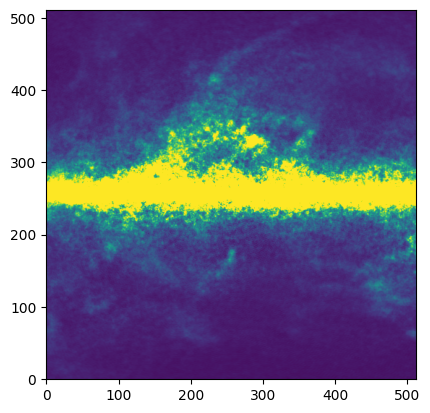

In [25]:
plt.imshow(crop_image, vmin=0, vmax=700, origin="lower")

In [26]:
alm_car_crop = pixell.curvedsky.map2alm(crop_image,lmax=lmax)
cl_car_crop=pixell.curvedsky.alm2cl(alm_car_crop)

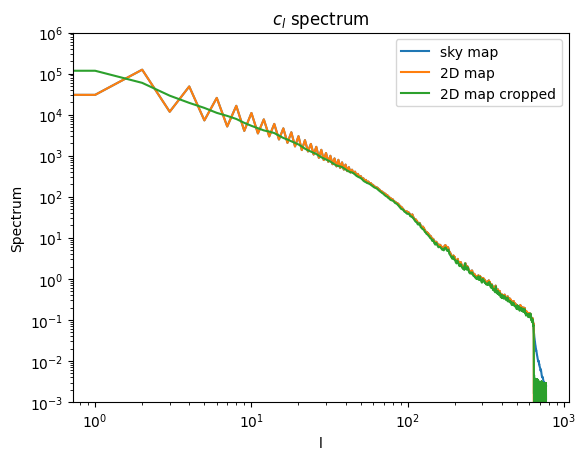

In [27]:
plt.plot(cl,label='sky map')
plt.plot(cl_car,label='2D map')
plt.plot(cl_car_crop,label='2D map cropped')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('l')
plt.ylabel('Spectrum')
plt.title(r'$c_l$ spectrum')
plt.ylim(1e-3,1e6)
plt.legend()

# Low resolution image

In [28]:
nside_lowres = 128  # 
seed=5
#pysm simulation
dust_lowres = pysm3.ModifiedBlackBodyRealization(
    nside=nside_lowres,
    amplitude_modulation_temp_alm="dust_gnilc/raw/gnilc_dust_temperature_modulation_alms_lmax768.fits.gz",
    amplitude_modulation_pol_alm="dust_gnilc/raw/gnilc_dust_polarization_modulation_alms_lmax768.fits.gz",
    largescale_alm="dust_gnilc/raw/gnilc_dust_largescale_template_logpoltens_alm_nside2048_lmax1024_complex64.fits.gz",
    small_scale_cl="dust_gnilc/raw/gnilc_dust_small_scales_logpoltens_cl_lmax16384.fits.gz",
    largescale_alm_mbb_index="dust_gnilc/raw/gnilc_dust_largescale_template_beta_alm_nside2048_lmax1024.fits.gz",
    small_scale_cl_mbb_index="dust_gnilc/raw/gnilc_dust_small_scales_beta_cl_lmax16384_2023.06.06.fits.gz",
    largescale_alm_mbb_temperature="dust_gnilc/raw/gnilc_dust_largescale_template_Td_alm_nside2048_lmax1024.fits.gz",
    small_scale_cl_mbb_temperature="dust_gnilc/raw/gnilc_dust_small_scales_Td_cl_lmax16384_2023.06.06.fits.gz",
    freq_ref="353 GHz",
    seeds=[seed, seed + 1000, seed + 2000],
    max_nside=8192,
)

sky_lowres = pysm3.Sky(nside=nside_lowres, component_objects=[dust_lowres])

m_lowres = sky_lowres.get_emission(freq)

/home/javierhn/venv_SR_map_generation/lib/python3.12/site-packages/healpy/fitsfunc.py:648: ComplexWarning: Casting complex values to real discards the imaginary part
  alm.real[i] = almr
/home/javierhn/venv_SR_map_generation/lib/python3.12/site-packages/healpy/fitsfunc.py:649: ComplexWarning: Casting complex values to real discards the imaginary part
  alm.imag[i] = almi
/home/javierhn/venv_SR_map_generation/lib/python3.12/site-packages/healpy/fitsfunc.py:648: ComplexWarning: Casting complex values to real discards the imaginary part
  alm.real[i] = almr
/home/javierhn/venv_SR_map_generation/lib/python3.12/site-packages/healpy/fitsfunc.py:649: ComplexWarning: Casting complex values to real discards the imaginary part
  alm.imag[i] = almi
/home/javierhn/venv_SR_map_generation/lib/python3.12/site-packages/healpy/sphtfunc.py:610: ComplexWarning: Casting complex values to real discards the imaginary part
  (np.asarray(cl, dtype=np.float64) if cl is not None else None)
/home/javierhn/venv_S

In [29]:
alm_lowres=hp.map2alm(m_lowres[0])
cl_lowres=pixell.curvedsky.alm2cl(alm_lowres)

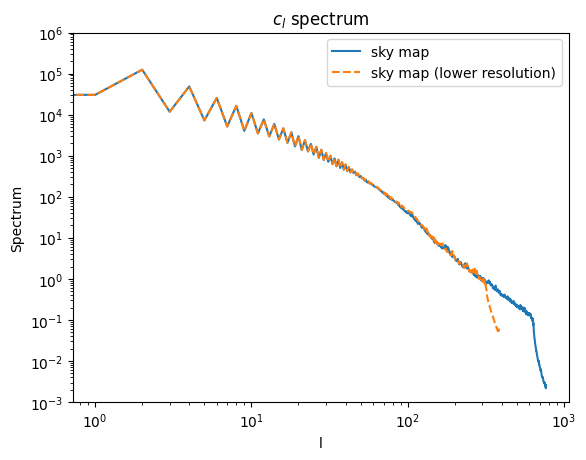

In [30]:
plt.plot(cl,label='sky map')
plt.plot(cl_lowres,linestyle='--',label='sky map (lower resolution)')
#plt.plot(cl_car,label='2D map')
#plt.plot(cl_car_crop,label='2D map cropped')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('l')
plt.ylabel('Spectrum')
plt.title(r'$c_l$ spectrum')
plt.ylim(1e-3,1e6)
plt.legend()

### Save image to file

In [31]:
crop_image.shape

(512, 512)

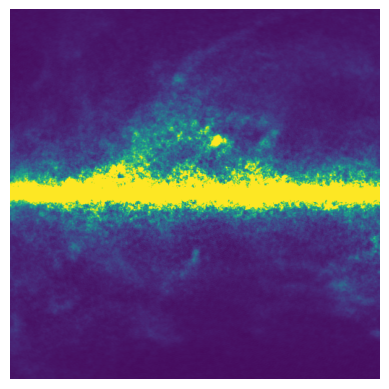

In [32]:
fig = plt.figure(frameon=False)
plt.imshow(crop_image, vmin=0, vmax=1000, origin="lower")
plt.axis('off')
#fig.savefig('out.png', bbox_inches='tight', pad_inches=0)
plt.imsave(fname='out.png', arr=crop_image, vmin=0, vmax=1000, origin="lower", format='png') #imsave save the array "as is"

## Read the data from the file

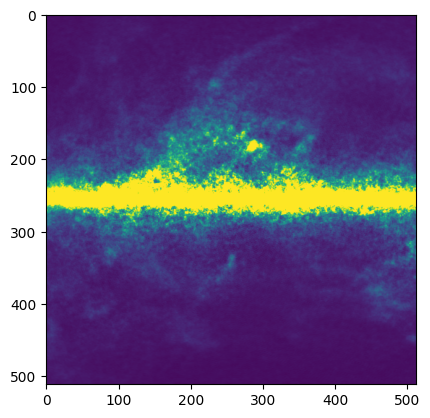

In [33]:
img = imread('out.png')
plt.imshow(img)

In [34]:
#calculate the cl from the read image
#alm_car_crop = 
cl_car_img_file=pixell.curvedsky.alm2cl(pixell.curvedsky.map2alm(img,lmax=lmax))

AttributeError: 'numpy.ndarray' object has no attribute 'wcs'